This notebook continues on the topic of regression and covers: multiple predictors, categorial predictors, and interactions.

# Multiple predictors

Up to now, we have had one predictor for the dependent variable: To what extent does study time correlate with, and predict exam score? But often we have multiple predictors that we suspect to play a role. Hinton's example is: Both the student's intelligence and the time they spent studying sound like reasonable predictors for their exam scores (where intelligence is quantified as an IQ score). How to quantify this? The problem is that in order to get good predictions of the correlation, we need to know how study time influences exam score once intelligence is taken out of the picture. 

Here is how to work through this in Python. First, here is the data.

In [13]:
import pandas as pd

studytime_df = pd.DataFrame({"participant":[1,2,3,4,5,6,7,8,9,10],
                            "studytime": [40,43,18,10,25,33,27,17,30,47],
                            "examscore": [58,73,56,47,58,54,45,32,68,69],
                            "iq":[118,128,110,114,138,120,106,124,132,130]})

studytime_df

participant  studytime  examscore   iq
0            1         40         58  118
1            2         43         73  128
2            3         18         56  110
3            4         10         47  114
4            5         25         58  138
5            6         33         54  120
6            7         27         45  106
7            8         17         32  124
8            9         30         68  132
9           10         47         69  130

First step: Are the different predictors correlated with each other? And with the dependent variable? We already know that study time in this dataset correlates with exam score. So to what extent does intelligence correlate with study time, and with exam performance? 

In [2]:
from scipy import stats

print("Correlation of study time and IQ:")
print(stats.pearsonr(studytime_df.studytime, studytime_df.iq))
print("Correlation of IQ and exam performance:")
print(stats.pearsonr(studytime_df.iq, studytime_df.examscore))


Correlation of study time and IQ:
(0.37314321429686065, 0.28822074809763004)
Correlation of IQ and exam performance:
(0.4832859281320025, 0.1570552699191584)


The correlation is sizeable in both cases, though not statistically significant (as we have little data). 

We would like to determine the amount of variance in exam score that is predicted by study time after IQ has been taken out of the picture. To do that, we first take IQ out of the picture by predicting both study time and eam score from IQ and using the residuals, that is, the variance in study time and in exam score that is not explained by IQ.

In [3]:
import statsmodels.formula.api as smf

# predicting study time from IQ
ols_studytime = smf.ols("studytime ~ iq", data= studytime_df).fit()
# predicting exam score from IQ
ols_examscore = smf.ols("examscore ~ iq", data= studytime_df).fit()

# computing the residuals
residual_studytime = ols_studytime.resid
residual_examscore = ols_examscore.resid

# are they correlated?
stats.pearsonr(residual_studytime, residual_examscore)

(0.6652977419205109, 0.0357812018420546)

Yes, there is a strong correlation between the variance in study time not explained by IQ, and the variance in exam score not explained by IQ. 

The formula for multiple linear regression for two predictors has the form

$Y = \beta_0 + \beta_1 x_1 + \beta_2 x_2$

and so on for more predictors.

The linear regression implementation in ```statsmodels``` can deal with multiple predictors. Here is how to put multiple predictors into the "formula" format that ```ols()``` takes as input:

In [4]:
ols_twopredictors = smf.ols("examscore ~ studytime + iq", data= studytime_df).fit()
ols_twopredictors.summary()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              examscore   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     4.693
Date:                Thu, 15 Apr 2021   Prob (F-statistic):             0.0510
Time:                        11:33:05   Log-Likelihood:                -34.616
No. Observations:                  10   AIC:                             75.23
Df Residuals:                       7   BIC:                             76.14
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2966     37.328      0.008      0.994     -87.969      88.562
studytime      0.6486      0.275      2.358      0.051      -0.002       1.299
iq             0.3024      0.323      0.935      0.381      -0.462       1.067
==============================================================================
Omnibus:                        1.671   Durbin-Watson:                   1.786
Prob(Omnibus):                  0.434   Jarque-Bera (JB):                0.609
Skew:                          -0.602   Prob(JB):                        0.737
Kurtosis:                       2.880   Cond. No.                     1.61e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.61e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

What do we see here?

* The coefficients for study time and IQ are both positive: higher study time and higher IQ both go with higher exam scores.
* Looking at the t tests for both coefficients, we see however that the slope for IQ is not significantly different from zero -- this is not a reliable predictor for exam score.
* The intercept is not interpretable when we have multiple predictors. 
* Residuals: Looking at the Omnibus and Jarque-Bera tests, the residuals again fail the test for normality (unsurprisingly, as this is a variant of the same dataset that failed normality of its residuals last time)
* Amount of variance explained: We get an R-squared value of 0.573. Now that we have multiple predictors, we see that the adjusted R-squared value, which adjusts for random variations in the data, is now quite a bit lower than the non-adjusted R-squared, and is at 0.451: We explain about 45% of the variance in exam scores with the predictors that we have. 
* How good is the model overall? Can we trust that not all slopes are really zero? The F-test shows a p-value of 0.051, which shows that the model probably does have value, though it is a bit borderline. This is even though the correlation of study time and exam score is so strong that you can actually see it in a plot of the data. The reason the model is dubious is that we have so few data points.


We now have a new problem, shown at the very bottom. There it says "The condition number is large, 1.61e+03. This might indicate that there are strong multicollinearity or other numerical problems." In fact, if the collinearity is above 20, that indicates worrying level of collinearity.

You can find the condition number in the last table, under **Cond. No.** You should always check the condition number to make sure you do not have an unduly high level of collinearity among your predictors. 

What should you do when you have a high level of collinearity among your predictors?
* First, this is a problem when you care to inspect the coefficients, that is, when you are doing data analysis. When you only care about the prediction result, collinearity is not a problem, because in that case you do not care so much about what the coefficient is for each predictor.
* If you are about the coefficients, then this is a problem. In that case, first think about your predictors: You have some predictors that tell pretty much the same story. Which ones are they? Can you just drop some of them? 
* If you decide you cannot and do not want to drop any of them, another option is to run principal component analysis over your predictors to obtain a new set of predictors that are mutually orthogonal. 

# ols output, annotated

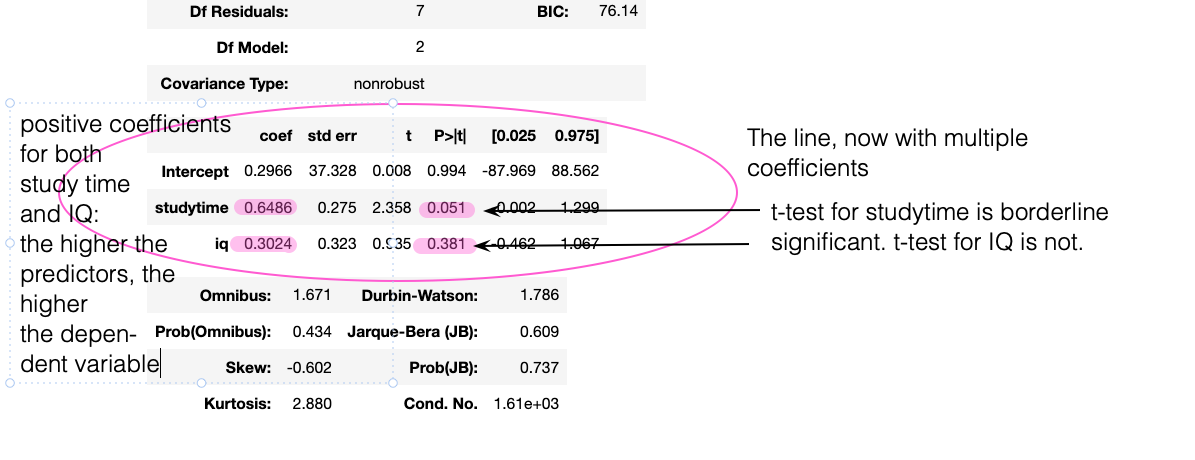

# Another dataset

**Try it for yourself:**

On Canvas, you find the file ```lexdec2.csv```, an extension of the lexical decision data we used before. It contains additional predictors, including the participants' subjective frequency ratings of words. The column ```SubjFreq``` contains these subjective frequencies, averaged over subjects.

Fit a linear regression model that uses both ```Frequency``` and ```SubjFreq``` as predictors for reaction time. 

* Do both coefficients have a slope that is significantly different from zero? 
* How much of the variance in reaction time do you explain with this model? (Please make sure to use the value that is adjusted for the number of predictors.) Is this better than the variance explained by the model that used only frequency as a predictor? 
* Does the model as a whole have value? Where do you see this?
* Are the residuals approximately normally distributed? How do you determine this? 

In [5]:
lexdec2_df = pd.read_csv("lexdec2.csv")
lexdec2_df.head()

Word  Frequency  meanRT  SubjFreq   Class  Complex
0     owl   4.859812  6.3582      3.12  animal  simplex
1    mole   4.605170  6.4150      2.40  animal  simplex
2  cherry   4.997212  6.3426      3.88   plant  simplex
3    pear   4.727388  6.3353      4.52   plant  simplex
4     dog   7.667626  6.2956      6.04  animal  simplex

# Categorial predictors

A categorial variable is a variable that takes one one of several distinct categories: yes versus no, blue versus yellow versus green, Texas versus Colorado versus New Mexico. 

Categorial variables are a problem because we somehow need to turn them into numbers in order to use them as predictors in a regression. But if we just encode, say, the state of origin as a number between 1 and 50, that indicates that states 1 and 2 are somehow closer together  than states 1 and 49. But that makes no sense for categories.

Here is an example to illustrate this: Say there have been four different package design for a new cereal, which were tested across a number of stores. Each store is randomly assigned a package design. Then we would like to know what the connection is between the package design and the number of items sold -- did some designs sell better than others? Here is a faulty encoding that just encodes blue as 1, red as 2, yellow as 3, and green as 4. We make up some sales numbers at random by drawing a number between 10 and 30 from a uniform distribution. First, here is how we draw 20 random integers between 10 and 30:

In [6]:
from scipy import stats

# this draws 20 random numbers between 0 and 1
print("Here are 20 random numbers between 0 and 1", stats.uniform.rvs(size = 20))
# this draws 20 random numbers between 10 and 30
print("Here are 20 random numbers between 10 and 30", stats.uniform.rvs(loc=10, scale = 20, size = 20))
# and this draws 20 random numbers between 10 and 30, integers only
print("Here are 20 random integers between 10 and 30", 
     [round(val) for val in stats.uniform.rvs(loc = 10, scale = 20, size = 20)])

Here are 20 random numbers between 0 and 1 [0.92365323 0.50499755 0.81465005 0.91652947 0.78754762 0.0983289
 0.58256167 0.43721868 0.85807323 0.71901738 0.31263082 0.92505232
 0.565689   0.54368638 0.85456825 0.99118295 0.90244907 0.53640021
 0.639402   0.90293479]
Here are 20 random numbers between 10 and 30 [17.31127331 21.09814648 14.00019978 26.88181994 28.00125672 24.04358013
 11.06756614 29.35417117 24.19600962 23.40675603 23.89773992 28.58714708
 11.69962257 25.44360575 12.83877929 13.01877639 16.49801277 24.6725053
 24.9628653  16.86961988]
Here are 20 random integers between 10 and 30 [23.0, 16.0, 19.0, 18.0, 18.0, 12.0, 24.0, 27.0, 18.0, 15.0, 11.0, 11.0, 17.0, 21.0, 24.0, 27.0, 28.0, 13.0, 17.0, 18.0]


We use this to make up our fake data for 20 stores: 

In [7]:
random_sales = [round(val) for val in stats.uniform.rvs(loc = 10, scale = 20, size = 20)]

Now we make a *broken* data frame in which we wrongly code colors as numbers. 5 stores get the yellow design, 5 the blue, 5 the green, and 5 the red:

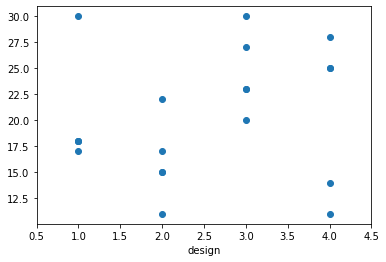

In [8]:
import pandas as pd


cereal_df_broken = pd.DataFrame( { "design" : [1,1,1,1,1,2,2,2,2,2,3,3,3,3,3,4,4,4,4,4],
                            "sales":random_sales})

# let's plot this
%matplotlib inline
cereal_df_broken.plot(x = "design", y = "sales", style = "o", xlim = (0.5, 4.5), legend = False);

So, what does linear regression make of this?

In [9]:
import statsmodels.formula.api as smf

smf.ols("sales ~ design", data= cereal_df_broken).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                 -0.017
Method:                 Least Squares   F-statistic:                    0.6790
Date:                Thu, 15 Apr 2021   Prob (F-statistic):              0.421
Time:                        11:33:05   Log-Likelihood:                -62.982
No. Observations:                  20   AIC:                             130.0
Df Residuals:                      18   BIC:                             132.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     17.9000      3.257      5.496      0.000      11.057      24.743
design         0.9800      1.189      0.824      0.421      -1.519       3.479
==============================================================================
Omnibus:                        0.016   Durbin-Watson:                   2.100
Prob(Omnibus):                  0.992   Jarque-Bera (JB):                0.223
Skew:                           0.001   Prob(JB):                        0.895
Kurtosis:                       2.483   Cond. No.                         7.47
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This hallucinates some relation about how sales change linearly as the design number rises by one unit -- which makes no sense at all. 

Instead we need to let ```ols()``` know that design is a categorial variable:

In [10]:
cereal_df = pd.DataFrame( { "design" : ["yellow","yellow", "yellow", "yellow", "yellow",
                                        "blue", "blue", "blue", "blue", "blue",
                                        "green", "green", "green", "green", "green", 
                                        "red", "red","red","red","red"],
                           "sales":random_sales})

smf.ols("sales ~ design", data= cereal_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     2.080
Date:                Thu, 15 Apr 2021   Prob (F-statistic):              0.143
Time:                        11:33:05   Log-Likelihood:                -60.059
No. Observations:                  20   AIC:                             128.1
Df Residuals:                      16   BIC:                             132.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           16.0000      2.437      6.565      0.000      10.833      21.167
design[T.green]      8.6000      3.447      2.495      0.024       1.293      15.907
design[T.red]        4.6000      3.447      1.335      0.201      -2.707      11.907
design[T.yellow]     4.2000      3.447      1.219      0.241      -3.107      11.507
==============================================================================
Omnibus:                        0.277   Durbin-Watson:                   2.588
Prob(Omnibus):                  0.871   Jarque-Bera (JB):                0.444
Skew:                           0.188   Prob(JB):                        0.801
Kurtosis:                       2.374   Cond. No.                         4.79
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Here is how to read this: One category's mean becomes the intercept. Here it is blue. The "slope" on all other categories is the difference from the mean value for blue packages. As can be seen from the probabilities associated with the t-tests for all coefficients, there is no significant difference between categories in this case -- which makes sense, since we randomly drew the sales values for all four categories from a uniform distribution. 

# An actual dataset with categorial predictors: lexical decision times, again


We again use the file ```lexdec2.csv``` with data on lexical decision times. There are two additional predictors: ```Complex``` says whether the word is morphologically complex. It has two categorial values, "complex" and "simplex". ```Class``` contains the category that the word came from. This whole dataset only has animals and plants, and ```Class``` encodes whether the word describes an animal or plant.

Choose one of the two categorial variables, and use it as a predictor of reaction time. First use it on its own, then together with Frequency.

* What list of coefficients do you get? what are they saying? Is each coefficient truly different from zero?
* How much of the variance in reaction time do you explain with this model? (Please make sure to use the value that is adjusted for the number of predictors.) Is this better than the variance explained by the model that used only frequency as a predictor? 
* Does the model as a whole have value? Where do you see this?
* Are the residuals approximately normally distributed? How do you determine this? 


In [11]:
import pandas as pd

lexdec_df = pd.read_csv("lexdec2.csv")
lexdec_df.head()

Word  Frequency  meanRT  SubjFreq   Class  Complex
0     owl   4.859812  6.3582      3.12  animal  simplex
1    mole   4.605170  6.4150      2.40  animal  simplex
2  cherry   4.997212  6.3426      3.88   plant  simplex
3    pear   4.727388  6.3353      4.52   plant  simplex
4     dog   7.667626  6.2956      6.04  animal  simplex

In [12]:
lexdec_df[lexdec_df.Complex == "complex"].Word

5     blackberry
6     strawberry
11      reindeer
12     blueberry
16      eggplant
18        peanut
33      beetroot
37     pineapple
68    woodpecker
73     butterfly
Name: Word, dtype: object

In [15]:
ols_obj = smf.ols("meanRT ~ Complex", data = lexdec_df).fit()
ols_obj.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 meanRT   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9937
Date:                Thu, 15 Apr 2021   Prob (F-statistic):              0.322
Time:                        12:07:44   Log-Likelihood:                 91.141
No. Observations:                  79   AIC:                            -178.3
Df Residuals:                      77   BIC:                            -173.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              6.4016      0.024    261.817      0.000       6.353       6.450
Complex[T.simplex]    -0.0261      0.026     -0.997      0.322      -0.078       0.026
==============================================================================
Omnibus:                       11.242   Durbin-Watson:                   2.105
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.433
Skew:                           0.869   Prob(JB):                      0.00329
Kurtosis:                       3.672   Cond. No.                         5.45
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# ols output, annotated

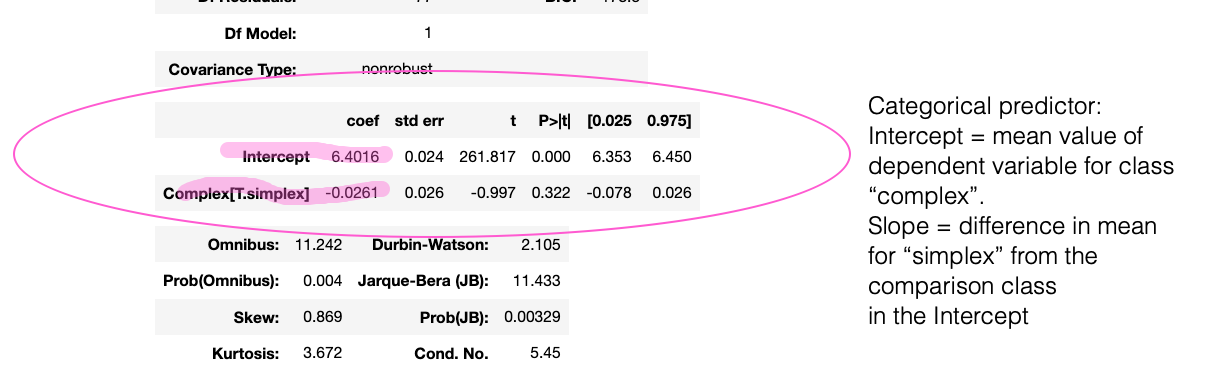

In [16]:
# now, animals versus plants:
ols_obj = smf.ols("meanRT ~ Class", data = lexdec_df).fit()
ols_obj.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 meanRT   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.2031
Date:                Thu, 15 Apr 2021   Prob (F-statistic):              0.654
Time:                        12:15:31   Log-Likelihood:                 90.738
No. Observations:                  79   AIC:                            -177.5
Df Residuals:                      77   BIC:                            -172.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          6.3824      0.012    544.756      0.000       6.359       6.406
Class[T.plant]    -0.0079      0.018     -0.451      0.654      -0.043       0.027
==============================================================================
Omnibus:                        8.707   Durbin-Watson:                   2.175
Prob(Omnibus):                  0.013   Jarque-Bera (JB):                8.507
Skew:                           0.786   Prob(JB):                       0.0142
Kurtosis:                       3.338   Cond. No.                         2.51
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
# now, animals versus plants:
ols_obj = smf.ols("meanRT ~ Class + Frequency", data = lexdec_df).fit()
ols_obj.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 meanRT   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.453
Method:                 Least Squares   F-statistic:                     33.32
Date:                Thu, 15 Apr 2021   Prob (F-statistic):           4.08e-11
Time:                        12:17:57   Log-Likelihood:                 115.50
No. Observations:                  79   AIC:                            -225.0
Df Residuals:                      76   BIC:                            -217.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          6.6061      0.029    229.344      0.000       6.549       6.663
Class[T.plant]    -0.0454      0.014     -3.302      0.001      -0.073      -0.018
Frequency         -0.0436      0.005     -8.140      0.000      -0.054      -0.033
==============================================================================
Omnibus:                       12.173   Durbin-Watson:                   2.272
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               16.432
Skew:                           0.664   Prob(JB):                     0.000270
Kurtosis:                       4.797   Cond. No.                         23.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""